#### Imports and introduction

This notebook will contain code to load data from the chunked pandas parquet PPO experience files (see `ProcessTrueStateActionData_with_prev_act.ipynb`).

It will then include a function to generate blue observations from true states and actions and then test it for correctness against real data.

In [288]:
import tensorflow as tf
from ray.rllib.offline.json_reader import JsonReader
import numpy as np
import numpy_indexed as npi
import pandas as pd
from IPython.display import display
import graphviz
import numpy as np
import ipywidgets as widgets
import os
from pathlib import Path

from CybORG import CybORG

from true_state_viewer import BlueObsTreeGraphViz, TrueStateTreeGraphViz
import ipywidgets as widgets
from IPython.display import display as idisplay
import inspect
from CybORG.Agents import B_lineAgent, SleepAgent, GreenAgent
from CybORG.Agents.Wrappers.rllib_wrapper import RLlibWrapper

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Loading and visualising the data

In [289]:
def create_empty_df():
    columns = []
    for node in range(13):
        columns.append(f"{node}_ts_pre_known_status")
        columns.append(f"{node}_ts_pre_access_status")

        columns.append(f"{node}_ts_blue_known_status")
        columns.append(f"{node}_ts_blue_access_status")

        columns.append(f"{node}_ts_red_known_status")
        columns.append(f"{node}_ts_red_access_status")

        columns.append(f"{node}_obs_blue_activity")
        columns.append(f"{node}_obs_blue_compromised")
        
        columns.append(f"{node}_prev_obs_blue_activity")
        columns.append(f"{node}_prev_obs_blue_compromised")

    columns.append(f"prev_action_blue")
    columns.append(f"action_blue")
    columns.append(f"reward")


    full_df = pd.DataFrame(columns=columns)
    return full_df

In [290]:
# chunks_data_path = "parquet_data/TrueStates_1221_4000_B_Line/chunks_100000/"
chunks_data_path = "parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/"

# chunks_data_path = "csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000_noprevs/"

full_df = create_empty_df()

# pathlist = Path(chunks_data_path).glob('**/*4*.parquet')
pathlist = Path(chunks_data_path).glob('**/*.parquet')
for path in sorted(pathlist):
    # because path is object not string
    print(f"loading chunk: {path}")
    chunk_df = pd.read_parquet(path)
    full_df = pd.concat([full_df, chunk_df])
    
df = full_df

loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_0.parquet
loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_1.parquet
loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_2.parquet
loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_3.parquet
loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_4.parquet
loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_5.parquet
loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_6.parquet
loading chunk: parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_7.parquet


In [291]:
def get_columns_for_training():
    true_states = ["pre","blue","red", "_"]
    ts_columns = {}
    for true_state in true_states:
        ts_columns[true_state] = []
        for node in range(13):
            ts_columns[true_state].append(f"{node}_ts_{true_state}_known_status")
            ts_columns[true_state].append(f"{node}_ts_{true_state}_access_status")
    ts_columns["obs"] = []
    for node in range(13):
        ts_columns["obs"].append(f"{node}_obs_blue_activity")
        ts_columns["obs"].append(f"{node}_obs_blue_compromised")
    ts_columns["pre_obs"] = []
    for node in range(13):
        ts_columns["pre_obs"].append(f"{node}_prev_obs_blue_activity")
        ts_columns["pre_obs"].append(f"{node}_prev_obs_blue_compromised")
    return ts_columns

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [292]:
def ts_to_one_hot(true_state_np):
    return tf.reshape(tf.one_hot(true_state_np,3),(-1,2,3))

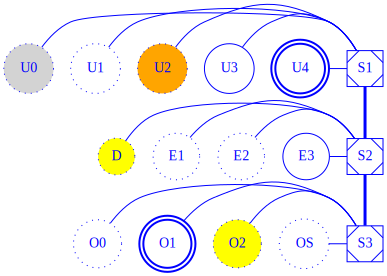

In [293]:
arr = np.array([[2,2],[2,3],[2,3],[1,3],[2,3],[0,3],[2,2],[2,3],[2,1],[2,3],[2,0],[1,3],[0,3]])
tree = BlueObsTreeGraphViz(arr)
tree.display()

In [294]:
len(df)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


800000

In [295]:
class DiscreteActionConverter:
    def __init__(self):
        path = str(inspect.getfile(CybORG))
        path = path[:-10] + '/Shared/Scenarios/Scenario2.yaml'
        agents = {"Red": B_lineAgent, "Green": GreenAgent}
        cyborg = CybORG(scenario_file=path, environment='sim', agents=agents)
        self.env = RLlibWrapper(env=cyborg, agent_name="Blue", max_steps=100)
        self.hosts = self.env.env.env.env.env.env.environment_controller.scenario.hosts
    
    def get_host_index_from_host(self, host: str):
        return self.hosts.index(host)
    
    def get_host_from_host_index(self, index: int):
        return self.hosts[index]
    
    def get_action_from_index(self, int_action: int):
        return self.env.env.env.possible_actions[int_action]
    
    def get_host_from_action(self, action_obj):
        return action_obj.hostname if "hostname" in action_obj.get_params() else "all"
    
    def get_host_index_from_action(self, action_obj):
        return self.get_host_index_from_host(action_obj.hostname) if "hostname" in action_obj.get_params() else None
    
    def get_action_name_from_action(self, action_obj):
        return action_obj.__class__.__name__
    
    def get_action_vbox(self, int_action: int, layout: widgets.Layout):
        action_obj = self.get_action_from_index(int_action)
        int_action_label = widgets.Label(f"{int_action}")
        action_name_label =  widgets.Label(self.get_action_name_from_action(action_obj))
        hostname_label = widgets.Label(self.get_host_from_action(action_obj))
        result = widgets.VBox([int_action_label, action_name_label, hostname_label], layout=layout)
        
        return result
       
        

In [333]:
def display_transitions(pre_obs, pre_action, pre_state, blue_state, red_state, post_obs, pred_obs):

    action_converter = DiscreteActionConverter()

    rows = []

    labels = []
    labels.append(widgets.Label("Step", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='2%')))

    labels.append(widgets.Label("Pre Obs", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='14%')))
    # labels.append(widgets.Label("Obs", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='15%')))
    labels.append(widgets.Label("Pre Action", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='14%')))

    labels.append(widgets.Label("Pre State", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='14%')))
    labels.append(widgets.Label("Blue Action State", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='14%')))
    labels.append(widgets.Label("Red Action State", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='14%')))
    labels.append(widgets.Label("Post Obs", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='14%')))
    
    labels.append(widgets.Label("Pred Obs", layout=widgets.Layout(display="flex", justify_content="center", border="solid", width='14%')))


    rows.append(widgets.HBox(labels))

#     for i, df_index in enumerate(range(start, stop,1)):
    for i in range(len(pre_obs)):
        cols = []

        cols.append(widgets.Label(f"{i}", layout=widgets.Layout(display="flex", justify_content="flex-start", width='2%')))

        tree = BlueObsTreeGraphViz(np.reshape(pre_obs[i], (-1,2)))
        cols.append(widgets.Image(value = tree.g.pipe(), format='png', width='14%'))
    #     tree = BlueObsTreeGraphViz(np.reshape(blue_obs_df.iloc[df_index,:].values, (-1,2)))
    #     cols.append(widgets.Image(value = tree.g.pipe(), format='png', width='15%'))

        cols.append(action_converter.get_action_vbox(pre_action[i], layout=widgets.Layout(display="flex", justify_content="flex-start", width='14%')))
    #     cols.append(widgets.Label("hello \n hello", layout=widgets.Layout(display="flex", flex_flow="row wrap",width='15%')))

        tree = TrueStateTreeGraphViz(ts_to_one_hot(pre_state[i]))
        cols.append(widgets.Image(value = tree.g.pipe(), format='png', width='14%'))

        tree = TrueStateTreeGraphViz(ts_to_one_hot(blue_state[i]))
        cols.append(widgets.Image(value = tree.g.pipe(), format='png', width='14%'))

        tree = TrueStateTreeGraphViz(ts_to_one_hot(red_state[i]))
        cols.append(widgets.Image(value = tree.g.pipe(), format='png', width='14%'))

        tree = BlueObsTreeGraphViz(np.reshape(post_obs[i], (-1,2)))
        cols.append(widgets.Image(value = tree.g.pipe(), format='png', width='14%'))
        
        tree = BlueObsTreeGraphViz(np.reshape(pred_obs[i], (-1,2)))
        cols.append(widgets.Image(value = tree.g.pipe(), format='png', width='14%'))



        rows.append(widgets.HBox(cols))

    step_table = widgets.VBox(rows) 
    idisplay(step_table)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [297]:
cols_dict = get_columns_for_training()
blue_pre_obs_df = df[cols_dict["pre_obs"]]
# blue_pre_obs_df = df[cols_dict["obs"]]
pre_ts_df = df[cols_dict["pre"]]
blue_pre_actions_df = df["prev_action_blue"]
blue_actions_df = df["action_blue"]
blue_ts_df = df[cols_dict["blue"]]
red_ts_df = df[cols_dict["red"]]
blue_obs_df = df[cols_dict["obs"]]

# start, stop = 1100000,1100100
# start, stop = 350600,350700
start, stop = 80600,80700
display_transitions(blue_pre_obs_df.iloc[start:stop,:].values,
                    blue_pre_actions_df.iloc[start:stop].values,
                    pre_ts_df.iloc[start:stop,:].values,
                    blue_ts_df.iloc[start:stop,:].values,
                    red_ts_df.iloc[start:stop,:].values,
                    blue_obs_df.iloc[start:stop,:].values,
                    blue_obs_df.iloc[start:stop,:].values)

In [298]:
blue_actions_df.max()

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


144

In [299]:
blue_pre_actions_df.min()

0

In [300]:
path = str(inspect.getfile(CybORG))
path = path[:-10] + '/Shared/Scenarios/Scenario2.yaml'
agents = {"Red": B_lineAgent, "Green": GreenAgent}
cyborg = CybORG(scenario_file=path, environment='sim', agents=agents)
env = RLlibWrapper(env=cyborg, agent_name="Blue", max_steps=100)



In [107]:
# env.env.env.env.env.env.environment_controller.__class__.__name__
env.env.env.env.env.env.environment_controller.scenario.hosts

['Defender',
 'Enterprise0',
 'Enterprise1',
 'Enterprise2',
 'Op_Host0',
 'Op_Host1',
 'Op_Host2',
 'Op_Server0',
 'User0',
 'User1',
 'User2',
 'User3',
 'User4']

### Manual observation generation

In [174]:
blue_is_unknown = np.array(np.reshape(blue_ts_df.iloc[700:720,:].values, [-1,13,2])[:,:,0]==0,copy=True)
blue_is_known =  np.array(np.reshape(blue_ts_df.iloc[700:720,:].values, [-1,13,2])[:,:,0]==1,copy=True)

red_is_known =  np.array(np.reshape(red_ts_df.iloc[700:720,:].values, [-1,13,2])[:,:,0]==1,copy=True)
red_is_scanned =  np.array(np.reshape(red_ts_df.iloc[700:720,:].values, [-1,13,2])[:,:,0]==2,copy=True)

new_scans = np.logical_and(blue_is_known, red_is_scanned)
# new_knowns = np.logical_and(blue_is_unknown, red_is_known)

print(new_scans)


blue_obs = np.array(np.reshape(blue_pre_obs_df.iloc[700:720,:].values,[-1,13,2]),copy=True)
# print(blue_obs[:,:,0])
# blue_obs[:,:,0] = 2.
# print(blue_obs[:,:,0])

print(blue_obs[new_scans,0])
blue_obs[new_scans,0] = np.random.choice([0,1],new_scans.sum(),p=[0.5,0.5])
print(blue_obs[new_scans])
print(np.logical_not(new_scans))
# print(blue_obs)

[[False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False  True
  False]
 [False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [False  True False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [False False False False False False False False False False False False
  False]
 [Fa

In [249]:
blue_obs = np.array(np.reshape(blue_pre_obs_df.iloc[700:800,:].values,[-1,13,2]),copy=True)
blue_obs[:,:,0] = 2.


blue_pre_acts = np.array(blue_pre_actions_df.iloc[700:800], copy=True)

disactconv = DiscreteActionConverter()
def action_int_to_info_array(a):
#     nonlocal disactconv
    act_obj = disactconv.get_action_from_index(a)
    act_name = disactconv.get_action_name_from_action(act_obj)
    is_remove = act_name == "Remove"
    is_restore = act_name == "Restore"
    is_analyse = act_name == "Analyse"
    host_index = disactconv.get_host_index_from_action(act_obj)
    if not host_index:
        host_index = 0
    return np.array([is_restore, is_remove, is_analyse, host_index],dtype=np.int32)

vectorised_act_to_info = np.vectorize(action_int_to_info_array, signature='()->(n)')

restore_rem_host = vectorised_act_to_info(blue_pre_acts)
restore_indices = restore_rem_host[:,0] == True
restore_hosts = restore_rem_host[restore_indices][:,3]
# print(blue_obs[restore_indices,restore_hosts])
blue_obs[restore_indices,restore_hosts,1] = 3.

# print(blue_obs[restore_indices,restore_hosts])
remove_indices = restore_rem_host[:,1] == True
print(remove_indices.shape)

# not_no_compromised[]
# print(restore_rem_host[:,2])
# print(blue_obs[np.arange(len(blue_obs)),restore_rem_host[:,2],1]<3.)
not_no_compromised = blue_obs[np.arange(len(blue_obs)),restore_rem_host[:,3],1]<3.
# print(not_no_compromised.shape)
remove_and_not_no_compromised = np.logical_and(remove_indices, not_no_compromised)
remove_hosts = restore_rem_host[remove_and_not_no_compromised,3]
# print(blue_obs[remove_indices,remove_hosts])
print(remove_hosts)
# remove_indices_not_no = blue_obs[remove_indices,remove_hosts,1] < 3.
# print(remove_indices_not_no)
# print(blue_obs[[1,4,5],[0,2,3]])
# print(blue_obs[remove_indices,remove_hosts][remove_indices_not_no,1])
# blue_obs[remove_indices,remove_hosts][remove_indices_not_no,1] = 2.
print(blue_obs[remove_and_not_no_compromised,remove_hosts,])
print(blue_obs[remove_and_not_no_compromised])
blue_obs[remove_and_not_no_compromised,remove_hosts,1] = 2.
print(blue_obs[remove_and_not_no_compromised,remove_hosts,])
print(blue_obs[remove_and_not_no_compromised])
# print(blue_obs[remove_indices,remove_hosts][remove_indices_not_no,1])
# print(blue_obs[remove_indices,remove_hosts])
# blue_obs[restore_indices,restore_hosts,1] = 3.

# print(blue_obs[restore_indices,restore_hosts])


(100,)
[3 3]
[[2. 1.]
 [2. 2.]]
[[[2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 1.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]]

 [[2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 2.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]]]
[[2. 2.]
 [2. 2.]]
[[[2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 2.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]]

 [[2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 2.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]
  [2. 3.]]]


In [283]:
tf_arr = np.array([True,True,False,True,False])
tf_arr[tf_arr] = False
tf_arr

array([False, False, False, False, False])

In [330]:
class ObservationGenerator:
    def __init__(self):
        self.action_converter = DiscreteActionConverter()
        
        self.green_action_scan_hosts = ['User0',
                                        'User1',
                                        'User2',
                                        'User3',
                                        'User4',
                                        'Enterprise0',
                                        'Enterprise1',
                                        'Enterprise2',]
        self.green_action_scan_host_indices = []
        for host in self.green_action_scan_hosts:
            indx = self.action_converter.get_host_index_from_host(host)
            self.green_action_scan_host_indices.append(indx)
        
        def action_int_to_info_array(a):
            act_obj = self.action_converter.get_action_from_index(a)
            act_name = self.action_converter.get_action_name_from_action(act_obj)
            is_remove = act_name == "Remove"
            is_restore = act_name == "Restore"
            is_analyse = act_name == "Analyse"
            host_index = self.action_converter.get_host_index_from_action(act_obj)
            if not host_index:
                host_index = 0
            return np.array([is_remove, is_restore, is_analyse, host_index, ],dtype=np.int32)
            
        self.vectorised_act_to_info_func = np.vectorize(action_int_to_info_array, signature='()->(n)')
    
    # expecting numpy arrays of categorical int data with shape [batch_size, dims]
    def generate_observations(self, blue_state, red_state, prev_obs, action):
        # create copy of new obs from prev_obs (set all activities to none)
        new_obs = np.reshape(np.array(prev_obs, copy=True),[-1,13,2])
        new_obs[:,:,0] = 2.
        
        # RANDOM GREEN SCANS
        # add random scans
        # can only scan these: https://github.com/cage-challenge/cage-challenge-2/blob/f9303d37bd60a29a52db00c47c0b6b7d0e3402da/CybORG/CybORG/Agents/SimpleAgents/GreenAgent.py#L15
        # (User0-4 & Enterprise0-2)
        # one per turn with 50% change of no scan
        random_scan_indices = np.random.choice([True, False], len(new_obs))
        random_scan_hosts = np.random.choice(self.green_action_scan_host_indices, random_scan_indices.sum())        
        new_obs[random_scan_indices, random_scan_hosts, 0] = 1.
        
        # RED SCAN ACTIVITY
        # get new scans from blue_state => red_state (set to scan in activity)
        blue_is_unknown = np.reshape(blue_state, [-1,13,2])[:,:,0]==0
        blue_is_known =  np.reshape(blue_state, [-1,13,2])[:,:,0]==1
        red_is_known =  np.reshape(red_state, [-1,13,2])[:,:,0]==1
        red_is_scanned =  np.reshape(red_state, [-1,13,2])[:,:,0]==2

        new_scans = np.logical_and(blue_is_known, red_is_scanned)
        new_obs[new_scans,0] = 1.
        
        # NEW EXPLOIT ACTIVITY
        # get new user/priv from no access (set exploit with 95% chance)
        blue_is_no = np.reshape(blue_state, [-1,13,2])[:,:,1]==0
        red_is_user = np.reshape(red_state, [-1,13,2])[:,:,1]==1
        red_is_priv = np.reshape(red_state, [-1,13,2])[:,:,1]==2
        
        new_exploits = np.logical_and(blue_is_no, np.logical_or(red_is_user, red_is_priv))
        new_exploits[new_exploits] = np.random.choice([True,False],new_exploits.sum(),p=[0.95,0.05])
        # TODO: decide whether it matters that in _interpret_connections, the scan always overrides if connections>3 and ports>3..
        #         assert np.all(new_obs[new_exploits,0] != 1.)
#         see_exploits = np.random.choice([0.,2.],new_exploits.sum(),p=[0.95,0.05])

#         print(new_obs[new_exploits,0])
        new_obs[new_exploits,0] = 0.
#         print(new_obs[new_exploits,0])
#         print(new_obs[new_exploits,1])
        new_obs[new_exploits,1] = 1.
#         print(new_obs[new_exploits,1])
        
        
        # TODO: there seem to be extra scans present when red is attempting an exploit 
        # (could factor this in for nodes where scanned but not user and no escalation, choose one to add a scan obs to)
        
        
        # DYNAMIC BLUE ACTIONS:
        # look at action for restore and remove, set to no or unknown as appropriate
        restore_rem_host = self.vectorised_act_to_info_func(action)
        
        # Get action indices that are restore actions and of those get a list of hosts
        restore_indices = restore_rem_host[:,1] == True
        restore_hosts = restore_rem_host[restore_indices,3]
        # Set all compromised fields for the restore action hosts to "No"
        new_obs[restore_indices,restore_hosts,1] = 3.

        # Get action indices that are remove actions 
        remove_indices = restore_rem_host[:,0] == True
        
        # Get indices from blue obs where the compromised field of the host column selected 
        # by the action specified hosts is not "No"
        not_no_compromised = new_obs[np.arange(len(new_obs)),restore_rem_host[:,3],1]<3.
        # Get row indices of the obs where both the above conditions are met 
        # (i.e. action is remove and the specified host is not "No")
        remove_and_not_no_compromised = np.logical_and(remove_indices, not_no_compromised)
        remove_hosts = restore_rem_host[remove_and_not_no_compromised,3]
        # Set the compromised fields for the selected rows and hosts to "Unknown"
        new_obs[remove_and_not_no_compromised,remove_hosts,1] = 2.
         
        # ANALYSE ACTION
        # if analyse and privileged, set obs to priv
        analyse_indices = restore_rem_host[:,2] == True
        action_hosts = restore_rem_host[:,3]
        # TODO: should be blue rather than red make sure this is tested
        blue_ts_priv_indices = blue_state[np.arange(len(new_obs)), action_hosts,1] == 2.
        analyse_and_priv_indices = np.logical_and(analyse_indices, blue_ts_priv_indices)
        
        analyse_hosts = restore_rem_host[analyse_and_priv_indices,3]
        new_obs[analyse_and_priv_indices,analyse_hosts,1] = 0.
        
        return new_obs
        
        
    def test_obs_gen(self, blue_state, red_state, prev_obs, action, pred_obs):
        # all compromised should match
        # all activity where state change should match (apart from 95% of exploits.. need to handle this..? Or not, just add those cases up)
        # scans should be some percentage of the time on specific nodes, compare stats on this
        # some exploits happen some percentage of the time on already exploited nodes, compare stats on this
        return True
        
    def validate_obs(self, blue_state, red_state, action, pred_obs):
        # returns between probability whether the pred_obs could have come from the given state transition and action
        # need to run this on all training data to check my rules are correct
        return True
            

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [334]:
blue_pre_obs_df = df[cols_dict["pre_obs"]]
# blue_pre_obs_df = df[cols_dict["obs"]]
pre_ts_df = df[cols_dict["pre"]]
blue_pre_actions_df = df["prev_action_blue"]
blue_actions_df = df["action_blue"]
blue_ts_df = df[cols_dict["blue"]]
red_ts_df = df[cols_dict["red"]]
blue_obs_df = df[cols_dict["obs"]]
start, stop = 799900, 800000

obs_gen = ObservationGenerator()
blue_pred_obs = obs_gen.generate_observations(np.reshape(blue_ts_df.iloc[start:stop,:].values,[-1,13,2]), 
                                              np.reshape(red_ts_df.iloc[start:stop,:].values,[-1,13,2]),
                                              np.reshape(blue_pre_obs_df.iloc[start:stop,:].values,[-1,13,2]),
                                              blue_pre_actions_df.iloc[start:stop].values)

# start, stop = 1100000,1100100
# start, stop = 350600,350700

display_transitions(blue_pre_obs_df.iloc[start:stop,:].values,
                    blue_pre_actions_df.iloc[start:stop].values,
                    pre_ts_df.iloc[start:stop,:].values,
                    blue_ts_df.iloc[start:stop,:].values,
                    red_ts_df.iloc[start:stop,:].values,
                    blue_obs_df.iloc[start:stop,:].values,
                    blue_pred_obs)